# Model analysis

In [1]:
import os
import sys

sys.path.append(os.getcwd())
os.chdir("../..")

import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [3]:
from inference_model.utils import dill_load
from inference_model.training.utils import get_feature_importance
from inference_model.eda.target.analysis import correlation
from inference_model.eda.target.plotting import prob_distrib_per_class
from sklearn.model_selection import train_test_split
from pprint import pprint
import lightgbm as lgb
from inference_model.training.utils import to_lgbdataset
import shap
import warnings
import numpy as np
import ast

In [4]:
trainer = dill_load("lgbm_trainer.dill")

In [5]:
# 1. get/create some example data
with open("data/log_tiguan_27_mar_dac.txt") as f:
    data = ast.literal_eval(f.read())

df_pd = pd.DataFrame()
for data_value in data:
    temp_df = pd.DataFrame(data_value[list(data_value)[0]]).sort_values(
        by="ts_millis:", ascending=True
    )["value"]
    temp_df.rename(list(data_value)[0], inplace=True)
    df_pd = pd.concat([df_pd, temp_df], axis=1)

df_pd.dropna(inplace=True)
df_pd["class"] = 0
df_pd["car_id"] = "123abc"
df_pd.loc[:100, ["class"]] = 1
df_pd.loc[:100, ["engine_load"]] = 100

target_col = "class"
id_cols = ["car_id"]
cat_cols = []
cont_cols = df_pd.drop(
    columns=id_cols + cat_cols + [target_col]
).columns.values.tolist()
df_pd[cat_cols] = df_pd[cat_cols].astype(str)

valid_size = 0.2
test_size = 0.5

random_state = 1
df_train, df_valid = train_test_split(
    df_pd,
    test_size=valid_size,
    stratify=df_pd[trainer.target_col],
    random_state=random_state,
)
df_valid, df_test = train_test_split(
    df_valid,
    test_size=test_size,
    stratify=df_valid[trainer.target_col],
    random_state=random_state,
)

In [6]:
df_predicted_proba = trainer.predict_proba(
    df=df_test.drop(columns=trainer.target_col), binary2d=False
)
df_predicted_cls = trainer.predict_cls(df=df_test.drop(columns=trainer.target_col))

## Model feature importance and "certainty" of the model in predicting classes - probability density per class

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

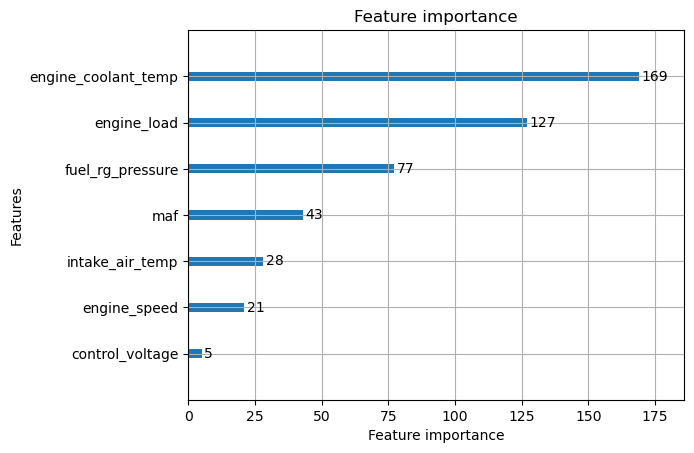

In [7]:
lgb.plot_importance(trainer.model, importance_type="split")
# lgb.plot_importance(trainer.model, importance_type="gain")

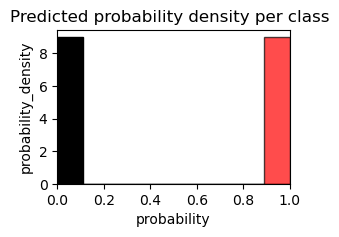

In [8]:
fig = prob_distrib_per_class(
    predicted_probs=df_predicted_proba.values.flatten(),
    actual=df_test[trainer.target_col].values.flatten(),
    task="binary",
)

## SHAP analysis

In [9]:
df_test_prep = trainer.preprocessors[0].transform(
    df_test.drop(columns=[trainer.target_col])
)
df_test_prep[trainer.target_col] = df_test[trainer.target_col].astype(int)

lgb_test, _ = to_lgbdataset(
    train=df_test_prep,
    cat_cols=trainer.cat_cols,
    target_col=trainer.target_col,
    id_cols=trainer.id_cols,
)

In [10]:
base_value = trainer.model.predict(data=lgb_test.data, pred_contrib=True)
shap_values = base_value[:, :-1]
base_value = np.mean(base_value[:, -1])

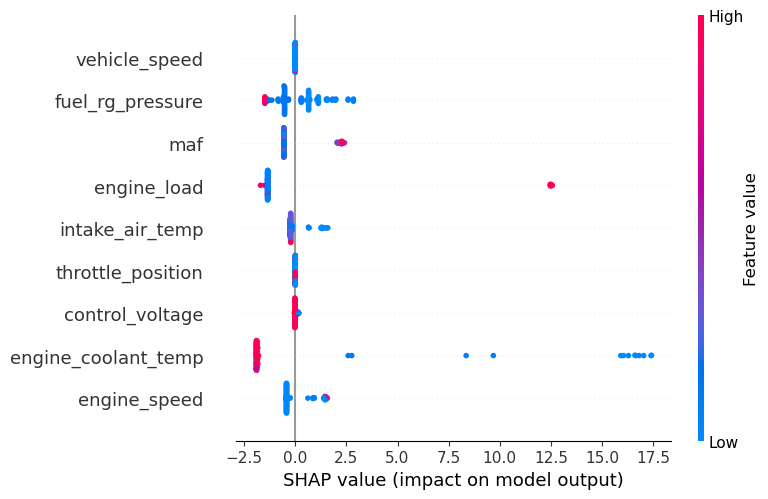

In [11]:
shap.summary_plot(
    shap_values, features=lgb_test.data, plot_type="dot", sort=False, show=True
)

In [19]:
df_predicted_cls[10:12]

,class
10,0
11,1


In [20]:
df_test.iloc[10:12]

,engine_load,engine_coolant_temp,engine_speed,vehicle_speed,intake_air_temp,maf,throttle_position,fuel_rg_pressure,barometric_pressure,control_voltage,class,car_id
579,38.04,89.0,895.5,0.0,22.0,9.77,83.14,34050.0,101.0,14.76,0,123abc
23,100.00,22.0,926.0,0.0,11.0,12.66,83.53,32160.0,101.0,14.72,1,123abc


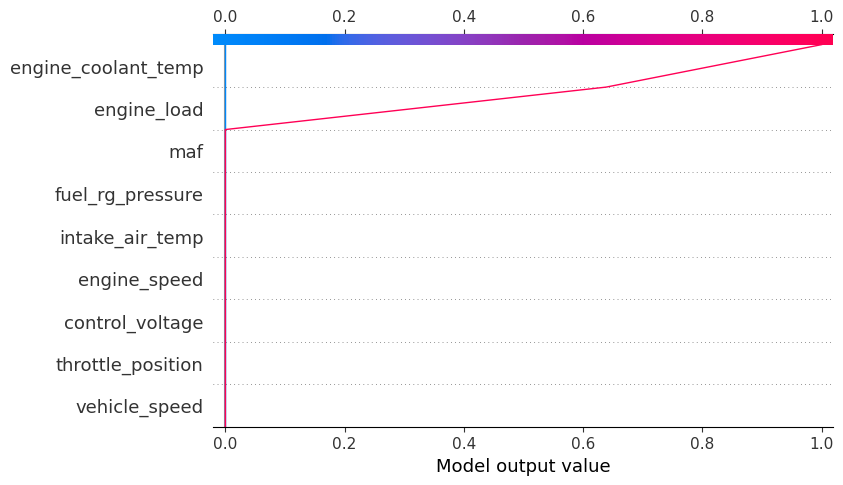

In [21]:
shap_decision_plot = shap.decision_plot(
    base_value=base_value,
    shap_values=shap_values[10:12],
    features=trainer.model.feature_name(),
    feature_names=trainer.model.feature_name(),
    # legend_labels=legend_labels,
    link="logit",
    # row_index=0,
    # feature_order=list(range(len(trainer.model.feature_name()))),
)